# **Movie Recommender System**

The following recommender systems will be built: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

The **ratings** dataset will be used. It contains the following attributes: 
- userId
- movieId
- rating
- timestamp

**Mounting Google drive on Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 39.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633727 sha256=ab3a46900190aedf1bc267f0eb2fc1b64f0aa3976c96028d417705e86ec86d00
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **Importing Libraries**

In [3]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries
import numpy as np                              
import pandas as pd
import matplotlib.pyplot as plt              
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

## **Loading the Data**

In [4]:
rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The timestamp column is not needed for the recommender system and it will be dropped.

In [6]:
rating = rating.drop(['timestamp'], axis=1)

## **Exploring the Data**


In [7]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


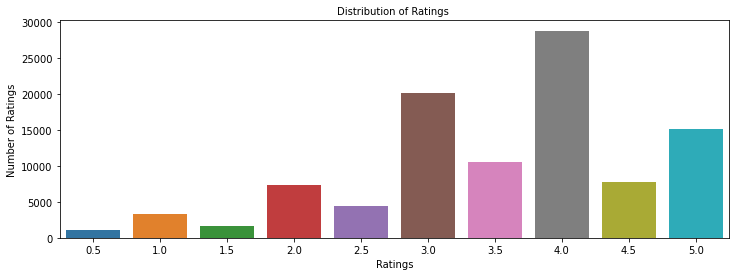

In [8]:
plt.figure(figsize = (12, 4))

sns.countplot(rating['rating'])

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [9]:
rating['userId'].nunique()

671

In [10]:
rating['movieId'].nunique()

9066

**User-Movie Interactions**

In [11]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [12]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

In [13]:
ratingCount = rating.groupby(['userId', 'movieId']).count()['rating']
ratingCount[ratingCount!=1]

Series([], Name: rating, dtype: int64)

**The output series above is empty: no movies that were interacted with more than once by the same user.**

**Most Interacted Movie**

In [14]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

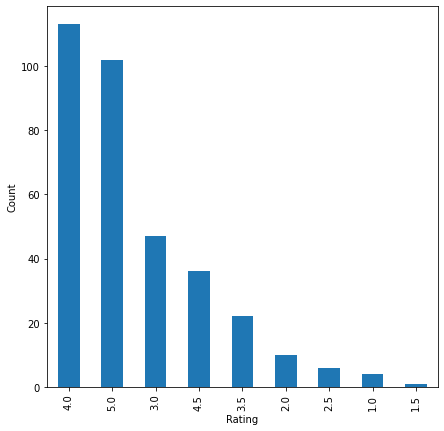

In [15]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))
rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**User with Most Interactions**

In [16]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Distribution of User-Movie Interactions**

In [17]:
rating.groupby('userId').count()

,movieId,rating
userId,,
1,20,20
2,76,76
3,51,51
4,204,204
5,100,100
...,...,...
667,68,68
668,20,20
669,37,37


In [18]:
# User-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

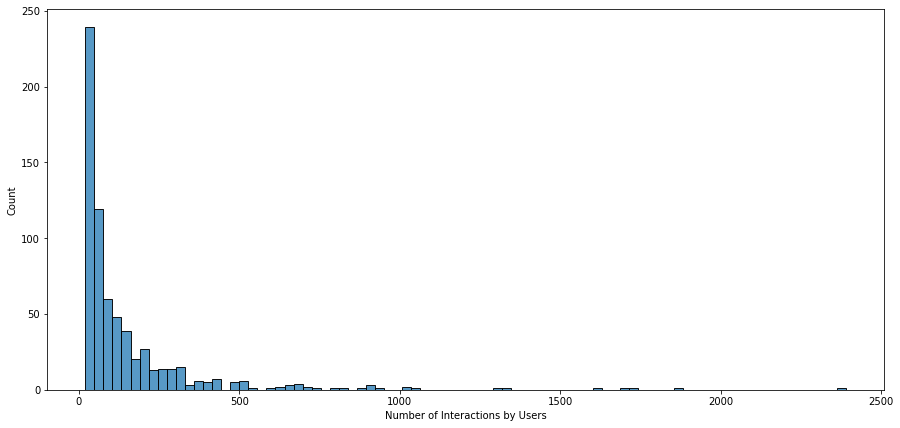

In [19]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

**Heavily skewed to the right (very few movies with a large number of ratings)**

## **Rank-Based Recommender System**

The **average** of all the ratings to each movie must be taken, which will then be used to rank the movies.

In [20]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [21]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [22]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

In [23]:
n_input = int(input("Enter a number n for the top n movies to recommend: "))
min_interactions_input = int(input("Enter a number for the minimum number of interactions: "))

list(top_n_movies(final_rating, n_input, min_interaction=min_interactions_input))

Enter a number n for the top n movies to recommend: 4
Enter a number for the minimum number of interactions: 50


[858, 318, 913, 1221]

## **User-Based Collaborative Filtering Recommender System**

### **Building a baseline user-user similarity based recommendation system**

**Transforming the dataset into surprise dataset and splitting it into train and test set**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

**Baseline similarity based recommendation system using cosine similarity and KNN**

In [25]:
# Defining Nearest neighbour algorithm
sim_options = {'name':'cosine','user_based':True}
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **Predicting rating using baseline user-based recommender system, given a user and movie**

In [26]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

algo_knn_user.predict(userId_input, movieId_input, r_ui=4, verbose=True)

Enter a user Id: 4
Enter a movie Id: 10
user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

### **Hyperparameter tuning for the baseline user based collaborative filtering recommendation system**

In [27]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9650783177451671
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search was **complete**, the **optimal values for each of those hyperparameters** was found.

Below is an analysis of evaluation metrics (RMSE and MAE at each and every split) to analyze the impact of each value of the hyperparameters.

In [28]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.968283,0.962785,0.964167,0.965078,0.002335,1,0.745618,0.737099,0.743203,0.741973,0.003585,1,0.202745,0.097739,3.376703,0.088918,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.996625,0.991229,0.993480,0.993778,0.002213,13,0.771390,0.762343,0.770338,0.768024,0.004040,12,0.642587,0.038549,3.522960,0.143957,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.971596,0.967182,0.969317,0.969365,0.001802,4,0.748367,0.740799,0.746986,0.745384,0.003291,3,0.189938,0.013736,4.504655,1.647393,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.998557,0.994281,0.996858,0.996565,0.001758,15,0.773034,0.764922,0.772648,0.770201,0.003736,15,0.759170,0.123747,3.351450,0.175147,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.978614,0.971589,0.975211,0.975138,0.002868,7,0.754129,0.744661,0.751987,0.750259,0.004054,6,0.284578,0.179579,3.711076,0.489549,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


**Building the final model by using tuned values of the hyperparameters, which were found using grid search cross-validation**



In [29]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values

sim_options = {'name':'msd','user_based':True}
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options,k=20,min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

**RMSE before tuning = 0.9925**

**RMSE after tuning = 0.9571**

### **Predicting rating using tuned user-based recommender system, given a user and movie**

In [30]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

similarity_algo_optimized_user.predict(userId_input,movieId_input, r_ui=4, verbose=True)

Enter a user Id: 4
Enter a movie Id: 10
user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

### **Identifying similar users to a given user (k- nearest neighbors)**

Similar users to a given user (or its nearest neighbors) can also be found based on the KNNBasic algorithm. The code below finds the k most similar users to a given userId based on msd distance.

In [32]:
userId_input = int(input("Enter the user Id: "))
k_input = int(input("Enter the value for k: "))

similarity_algo_optimized_user.get_neighbors(userId_input, k=k_input)

Enter the user Id: 4
Enter the value for k: 5


[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

In [33]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

### **Predicting the top n movies for a given userId with user-based recommender system**

In [34]:
userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input,similarity_algo_optimized_user)
recommendations

Enter a userId: 4
Enter a value for n: 10


[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148),
 (8933, 4.8139413850307395),
 (1192, 4.803341471563519),
 (6669, 4.794608813756791),
 (116, 4.793891781356206),
 (926, 4.787532124716758)]

## **Item-based Collaborative Filtering Recommender System**

### **Building a baseline item-item similarity based recommendation system**

In [35]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **Predicting rating using baseline item-based recommender system, given a user and movie**

In [36]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

algo_knn_item.predict(userId_input, movieId_input, r_ui=4, verbose=True)

Enter a user Id: 4
Enter a movie Id: 3
user: 4          item: 3          r_ui = 4.00   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

### **Hyperparameter tuning for the baseline item-based collaborative filtering recommender system**

In [37]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }


# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9396212914522751
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [38]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.954084,0.949625,0.945348,0.949685,0.003567,7,0.736330,0.735368,0.729190,0.733629,0.003163,7,9.738815,0.272778,13.354404,1.339872,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.015904,1.013525,1.009995,1.013141,0.002428,16,0.791359,0.792944,0.787596,0.790633,0.002243,16,21.490310,0.636004,11.468579,0.117477,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.954158,0.949784,0.945403,0.949781,0.003574,8,0.736458,0.735585,0.729207,0.733750,0.003232,8,8.563778,0.445286,12.293735,0.348322,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.015956,1.013730,1.010065,1.013250,0.002429,17,0.791457,0.793146,0.787635,0.790746,0.002305,17,22.541242,0.816470,12.482201,0.449275,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.954207,0.950408,0.945923,0.950180,0.003386,9,0.736611,0.736045,0.729708,0.734121,0.003130,9,7.425000,0.612711,12.386599,0.526667,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


**Building the final model**

In [39]:
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options, k=40, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9430


0.9430205750839428

**RMSE before tuning = 1.0032**

**RMSE after tuning = 0.9430**

### **Predicting rating using tuned item-based recommender system, given a user and movie**

In [40]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

similarity_algo_optimized_item.predict(userId_input, movieId_input, r_ui=4, verbose=True)

Enter a user Id: 4
Enter a movie Id: 10
user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

### **Identifying similar users to a given user (k- nearest neighbors)**


In [42]:
userId_input = int(input("Enter the user Id: "))
k_input = int(input("Enter the value for k: "))

similarity_algo_optimized_item.get_neighbors(userId_input, k=k_input)

Enter the user Id: 4
Enter the value for k: 5


[77, 85, 115, 119, 127]

### **Predicting the top n movies for a given userId with item-based recommender system**

In [44]:
userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input, similarity_algo_optimized_item)
recommendations

Enter a userId: 4
Enter a value for n: 5


[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

## **Model-Based Collaborative Filtering: Matrix Factorization using SVD**

### **Building a baseline matrix factorization recommender system**

In [43]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9020


0.9019589352751658

### **Predicting rating using baseline matrix factorization recommender system, given a user and movie**

In [45]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

algo_svd.predict(userId_input, movieId_input, r_ui=4, verbose=True)

Enter a user Id: 3
Enter a movie Id: 5
user: 3          item: 5          r_ui = 4.00   est = 3.05   {'was_impossible': False}


Prediction(uid=3, iid=5, r_ui=4, est=3.048569254136249, details={'was_impossible': False})

### **Hyperparameter tuning for the baseline SVD-based collaborative filtering recommender system**

In [46]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8940987626687585
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [47]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.944193,0.943238,0.942489,0.943307,0.000698,25,0.739571,0.736532,0.737994,0.738032,0.001241,25,5.047400,0.586397,0.640673,0.096115,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.947587,0.948037,0.947773,0.947799,0.000185,26,0.744619,0.741933,0.743768,0.743440,0.001121,26,4.816876,0.087664,0.660240,0.012504,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.953303,0.952856,0.952563,0.952907,0.000304,27,0.750663,0.747485,0.749202,0.749117,0.001299,27,4.990813,0.096883,0.776963,0.063871,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.908144,0.908147,0.905921,0.907404,0.001048,10,0.703797,0.702604,0.702455,0.702952,0.000601,9,4.949563,0.142305,0.752482,0.040410,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.914696,0.915152,0.913250,0.914366,0.000811,15,0.711123,0.710297,0.710452,0.710624,0.000358,15,6.044247,0.864450,0.867663,0.277224,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


**Building the final model**

In [48]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8953


0.8952822749469731

**RMSE before tuning = 0.9020**

**RMSE after tuning = 0.8953**

### **Predicting rating using SVD based collaborative filtering, given a user and movie**

In [49]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

svd_algo_optimized.predict(userId_input, movieId_input, r_ui=4, verbose=True)

Enter a user Id: 4
Enter a movie Id: 10
user: 4          item: 10         r_ui = 4.00   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9838527048011607, details={'was_impossible': False})

### **Predicting the top n movies for a given userId with SVD based recommender system**

In [50]:
userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input, svd_algo_optimized)
recommendations

Enter a userId: 4
Enter a value for n: 5


[(1192, 4.981238221792196),
 (116, 4.962514493324591),
 (3310, 4.954334303582053),
 (5114, 4.9484722481718455),
 (926, 4.935360469061581)]

### **Predicted vs Actual Ratings** 

In [51]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

**Input userId to compare predicted and actual ratings for a given user**

In [52]:
userId_input = int(input("Enter a user Id: "))

Enter a user Id: 7


**Predicted vs Actual Ratings with User-Based Recommender System**

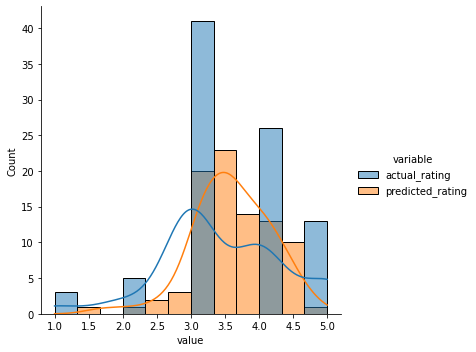

In [53]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, userId_input, similarity_algo_optimized_user)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Predicted vs Actual Ratings with Item-Based Recommender System**

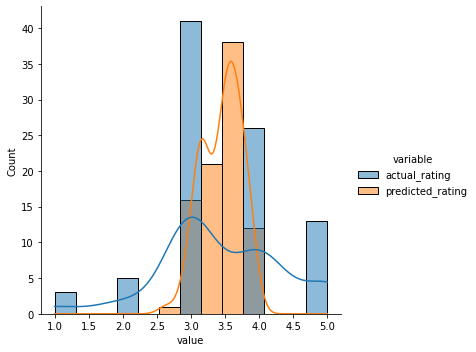

In [54]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, userId_input, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Predicted vs Actual Ratings with Matrix Factorization-Based Recommender System**

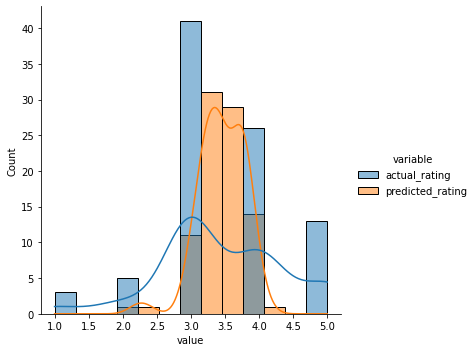

In [55]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, userId_input, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

### **Precision and recall for each of the 6 models**

In [ ]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [ ]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user, algo_knn_item, similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.765
-----> Recall:  0.404
> k=5, model=KNNBasic
-----> Precision:  0.773
-----> Recall:  0.418
> k=5, model=KNNBasic
-----> Precision:  0.611
-----> Recall:  0.328
> k=5, model=KNNBasic
-----> Precision:  0.681
-----> Recall:  0.354
> k=5, model=SVD
-----> Precision:  0.754
-----> Recall:  0.383
> k=5, model=SVD
-----> Precision:  0.75
-----> Recall:  0.385
> k=10, model=KNNBasic
-----> Precision:  0.747
-----> Recall:  0.548
> k=10, model=KNNBasic
-----> Precision:  0.752
-----> Recall:  0.56
> k=10, model=KNNBasic
-----> Precision:  0.6
-----> Recall:  0.473
> k=10, model=KNNBasic
-----> Precision:  0.66
-----> Recall:  0.507
> k=10, model=SVD
-----> Precision:  0.733
-----> Recall:  0.517
> k=10, model=SVD
-----> Precision:  0.731
-----> Recall:  0.525
